In [8]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim):
        super(PolicyNetwork, self).__init__()
        layers = []
        prev_size = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(prev_size, hs))
            layers.append(nn.ReLU())
            prev_size = hs
        layers.append(nn.Linear(prev_size, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.model(x)
        return torch.softmax(logits, dim=-1)


class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_sizes):
        super(ValueNetwork, self).__init__()
        layers = []
        prev_size = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(prev_size, hs))
            layers.append(nn.ReLU())
            prev_size = hs
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [91]:
def actor_critic(env,
                 input_dim,
                 output_dim,
                 hidden_sizes_theta,
                 hidden_sizes_w,
                 alpha_theta=0.001,
                 alpha_w=0.001,
                 episodes=500,
                 gamma=0.99,
                 log_dir="runs/actor_critic"):
    """
    One-step Actor-Critic (episodic).

    Args:
        env: OpenAI gym environment
        input_dim: dimension of input space
        output_dim: number of actions
        hidden_sizes_theta: list of sizes for each hidden layer
        hidden_sizes_w: list of sizes for each hidden layer
        alpha_theta: learning rate for the policy network
        alpha_w: learning rate for the value network
        episodes: number of training episodes
        gamma: discount factor
        log_dir: directory for tensorboard logs

    Returns:
        policy_network: the trained policy network
        rewards_per_episode: a list containing the total reward per episode
    """

    writer = SummaryWriter(log_dir=log_dir)

    policy_network = PolicyNetwork(input_dim, hidden_sizes_theta, output_dim).to(device)
    value_network = ValueNetwork(input_dim, hidden_sizes_w).to(device)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=alpha_theta)
    value_optimizer = optim.Adam(value_network.parameters(), lr=alpha_w)

    rewards_per_episode = []

    for episode in range(episodes):
        # generate a new episode
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        I = 1

        while not done:

            # make sure it does not run infinitely
            if total_reward > 50000:
                break

            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # compute policy and choose action
            action_probs = policy_network(state_tensor)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            log_prob_action = dist.log_prob(action)

            next_state, reward, done, truncated, info = env.step(action.item())
            total_reward += reward

            # compute value estimates
            value = value_network(state_tensor)
            with torch.no_grad():
                if done:
                    next_value = torch.tensor([[0.0]], dtype=torch.float32, device=device)
                else:
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                    next_value = value_network(next_state_tensor)

            # TD-error
            delta = reward + gamma * next_value - value

            # update value network
            value_loss = -value * delta.detach() * I
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            # update policy network
            policy_loss = -log_prob_action * delta.detach() * I
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update I
            I *= gamma

            state = next_state

        rewards_per_episode.append(total_reward)

        writer.add_scalar("Value Loss", value_loss.item(), episode)
        writer.add_scalar("Total Reward", total_reward, episode)

        # Early stopping if solved
        if len(rewards_per_episode) >= 100:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Average Reward: {avg_reward}")
            if avg_reward >= 475.0:
                print(f"Solved in {episode + 1} episodes!")
                break
        else:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    writer.close()
    return policy_network, value_network, rewards_per_episode

In [92]:
def test_policy(env, policy_network, episodes=10):
    policy_network.eval()
    avg_reward = 0
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action_probs = policy_network(state_tensor)
            action = torch.argmax(action_probs).item()
            state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if total_reward >= 10000:
                break

        avg_reward += total_reward
        print(f"Test Episode {ep + 1}, Total Reward: {total_reward}")
    return avg_reward / episodes

Episode 1/2000, Total Reward: 12.0
Episode 2/2000, Total Reward: 34.0
Episode 3/2000, Total Reward: 15.0
Episode 4/2000, Total Reward: 14.0
Episode 5/2000, Total Reward: 23.0
Episode 6/2000, Total Reward: 17.0
Episode 7/2000, Total Reward: 29.0
Episode 8/2000, Total Reward: 16.0
Episode 9/2000, Total Reward: 20.0
Episode 10/2000, Total Reward: 27.0
Episode 11/2000, Total Reward: 27.0
Episode 12/2000, Total Reward: 13.0
Episode 13/2000, Total Reward: 22.0
Episode 14/2000, Total Reward: 15.0
Episode 15/2000, Total Reward: 21.0
Episode 16/2000, Total Reward: 17.0
Episode 17/2000, Total Reward: 36.0
Episode 18/2000, Total Reward: 14.0
Episode 19/2000, Total Reward: 18.0
Episode 20/2000, Total Reward: 12.0
Episode 21/2000, Total Reward: 24.0
Episode 22/2000, Total Reward: 35.0
Episode 23/2000, Total Reward: 34.0
Episode 24/2000, Total Reward: 14.0
Episode 25/2000, Total Reward: 21.0
Episode 26/2000, Total Reward: 28.0
Episode 27/2000, Total Reward: 17.0
Episode 28/2000, Total Reward: 31.0
E

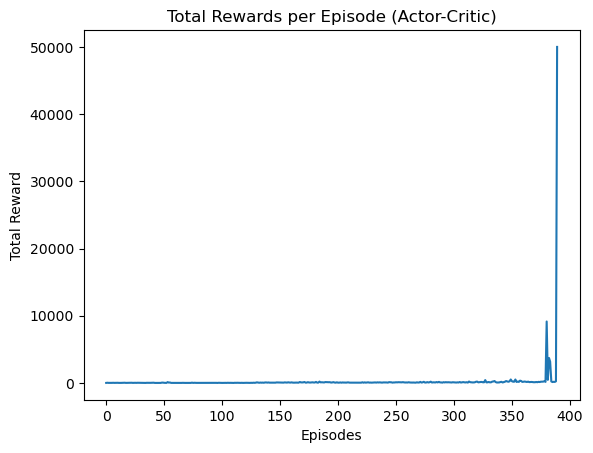

In [99]:
env = gym.make("CartPole-v1")

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

hidden_sizes_theta = [16, 32, 16]
hidden_sizes_w = [16, 32, 16]

episodes = 2000
gamma = 0.97
alpha_theta = 0.0008
alpha_w = 0.0008

policy_network, value_network, rewards = actor_critic(env,
                                                      input_dim=input_dim,
                                                      output_dim=output_dim,
                                                      hidden_sizes_theta=hidden_sizes_theta,
                                                      hidden_sizes_w=hidden_sizes_w,
                                                      alpha_theta=alpha_theta,
                                                      alpha_w=alpha_w,
                                                      episodes=episodes,
                                                      gamma=gamma)

plt.figure()
plt.plot(rewards)
plt.title("Total Rewards per Episode (Actor-Critic)")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

In [100]:
# test the trained policy
print("Testing the policy...")
test_avg_reward = test_policy(env, policy_network, episodes=100)
print(f"Average Test Reward: {test_avg_reward}")

Testing the policy...
Test Episode 1, Total Reward: 1260.0
Test Episode 2, Total Reward: 10000.0
Test Episode 3, Total Reward: 761.0
Test Episode 4, Total Reward: 662.0
Test Episode 5, Total Reward: 4306.0
Test Episode 6, Total Reward: 761.0
Test Episode 7, Total Reward: 800.0
Test Episode 8, Total Reward: 10000.0
Test Episode 9, Total Reward: 5405.0
Test Episode 10, Total Reward: 988.0
Test Episode 11, Total Reward: 10000.0
Test Episode 12, Total Reward: 1260.0
Test Episode 13, Total Reward: 1089.0
Test Episode 14, Total Reward: 3096.0
Test Episode 15, Total Reward: 557.0
Test Episode 16, Total Reward: 667.0
Test Episode 17, Total Reward: 10000.0
Test Episode 18, Total Reward: 4400.0
Test Episode 19, Total Reward: 10000.0
Test Episode 20, Total Reward: 724.0
Test Episode 21, Total Reward: 3379.0
Test Episode 22, Total Reward: 6153.0
Test Episode 23, Total Reward: 10000.0
Test Episode 24, Total Reward: 995.0
Test Episode 25, Total Reward: 10000.0
Test Episode 26, Total Reward: 10000.0


In [102]:
# save the policy and value networks
torch.save(policy_network.state_dict(), 'actor_critic_policy.pth')
torch.save(value_network.state_dict(), 'actor_critic_value.pth')